In [ ]:
try:

  %tensorflow_version 2.x
except Exception:
  pass
from  tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from keras.datasets import fashion_mnist

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
def create_pairs(x, digit_indices):

    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    print(digit_indices)
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

train_images=train_images.astype('float32')
test_images=test_images.astype('float32')


train_images=train_images/255.0
test_images=test_images/255.0

tr_pairs,tr_y=create_pairs_on_set(train_images,train_labels)
ts_pairs,ts_y=create_pairs_on_set(test_images,test_labels)





[array([    1,     2,     4, ..., 59974, 59985, 59998]), array([   16,    21,    38, ..., 59989, 59991, 59996]), array([    5,     7,    27, ..., 59977, 59981, 59993]), array([    3,    20,    25, ..., 59971, 59980, 59997]), array([   19,    22,    24, ..., 59984, 59986, 59990]), array([    8,     9,    12, ..., 59983, 59995, 59999]), array([   18,    32,    33, ..., 59973, 59987, 59988]), array([    6,    14,    41, ..., 59951, 59979, 59992]), array([   23,    35,    57, ..., 59962, 59967, 59994]), array([    0,    11,    15, ..., 59932, 59970, 59978])]
[array([  19,   27,   35,   59,   71,   85,   88,   96,  113,  120,  121,
        125,  141,  142,  143,  155,  164,  170,  177,  180,  201,  206,
        223,  229,  235,  260,  263,  264,  272,  275,  280,  284,  304,
        305,  332,  341,  355,  359,  370,  374,  381,  395,  400,  403,
        410,  440,  452,  454,  458,  463,  464,  472,  488,  489,  499,
        501,  531,  544,  547,  566,  577,  589,  605,  610,  616,  625,


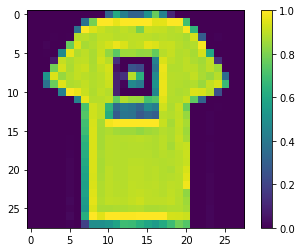

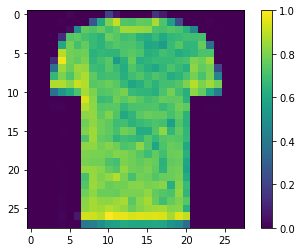

1.0


In [ ]:
# array index
this_pair = 20

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])



In [ ]:
def initialize_base_network():
  input=Input(shape=(28,28,),name="base_input")
  x=Flatten(name="flatten_input")(input)
  x=Dense(128,activation='relu',name="first_base_dense")(x)
  x=Dropout(0.1,name="first_dropout")(x)
  x=Dense(128,activation='relu',name="second_base_dense")(x)
  x=Dropout(0.1,name="second_dropout")(x)
  x=Dense(128,activation='relu',name="third_base_dense")(x)

  return Model(inputs=input,outputs=x)

def euclidean_distance(vects):
  x,y=vects
  sum_square=K.sum(K.square(x-y),axis=1,keepdims=True)
  return K.sqrt(K.maximum(sum_square,K.epsilon()))


def eucl_dist_output_shape(shapes):
  shape1,shape2=shapes
  return (shape1[0],1)


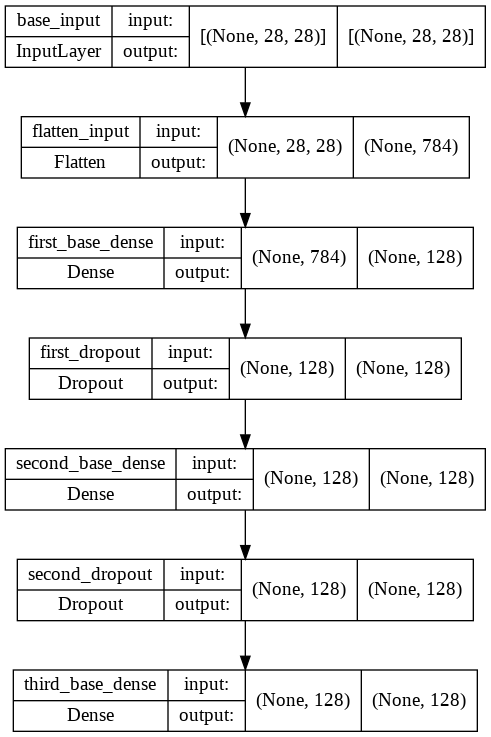

In [ ]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

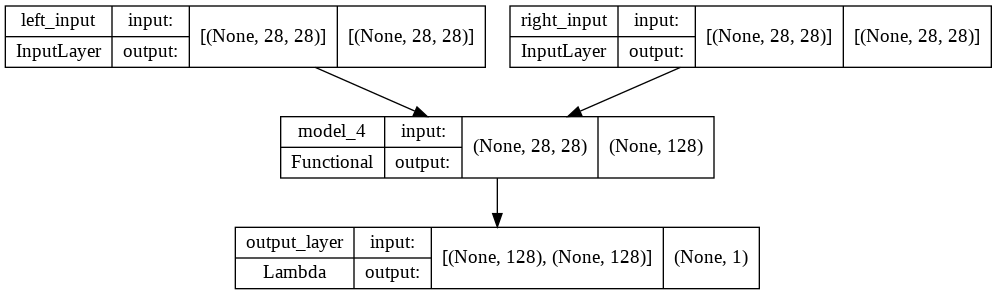

In [ ]:
input_a=Input(shape=(28,28,),name="left_input")
vect_output_a=base_network(input_a)

input_b=Input(shape=(28,28,),name="right_input")
vect_output_b=base_network(input_b)

output=Lambda(euclidean_distance,name="output_layer",output_shape= eucl_dist_output_shape)([vect_output_a,vect_output_b])

model=Model([input_a,input_b],output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [ ]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true,y_pred):
    square_pred=K.square(y_pred)
    margin_square=K.square(K.maximum(margin-y_pred,0))
    return (y_true*square_pred+(1-y_true)*margin_square)
  return contrastive_loss


rms=RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1),optimizer=rms)
history=model.fit([tr_pairs[:,0], tr_pairs[:,1]],tr_y,epochs=20,batch_size=128,validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))


Epoch 1/20
938/938 [==============================] - 10s 9ms/step - loss: 0.1114 - val_loss: 0.0868
Epoch 2/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0821 - val_loss: 0.0763
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0731 - val_loss: 0.0672
Epoch 4/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0670 - val_loss: 0.0690
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0640 - val_loss: 0.0684
Epoch 6/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0618 - val_loss: 0.0637
Epoch 7/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0597 - val_loss: 0.0646
Epoch 8/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0587 - val_loss: 0.0623
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0576 - val_loss: 0.0642
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0563 - val_los

In [ ]:
def compute_accuracy(y_true,y_pred):
  pred=y_pred.ravel()<0.5
  print(pred)
  return np.mean(pred==y_true)

In [ ]:
loss=model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]],y=ts_y)
y_pred_train=model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 2s 3ms/step - loss: 0.0622
[ True False False ... False  True False]
[ True False  True ... False  True False]
Loss = 0.06216874346137047, Train Accuracy = 0.9374562427071178 Test Accuracy = 0.9128128128128128


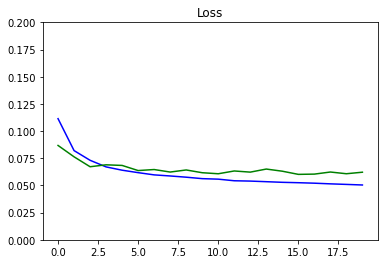

In [ ]:
def plot_metrics(metric_name,title,ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)


In [ ]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


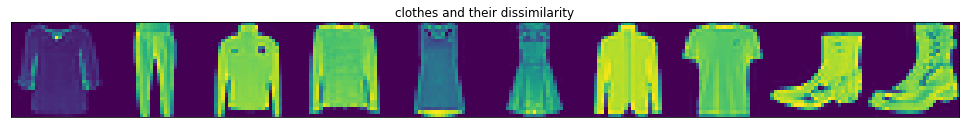

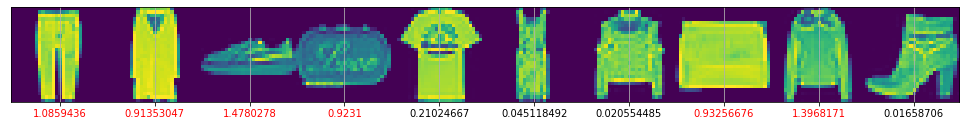

In [ ]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)